## <center> Artem Zaika: User authentication at the visited web pages

In this project we will solve the problem of identification of the user behavior on the Internet. This is a complex and interesting challenge at the intersection of data Analytics and behavioral psychology. As an example, Yandex solves the problem of identifying the attacker's mailbox by his behavior. In a nutshell, the attacker will behave not as the owner of the box: he may not delete messages immediately after reading, as did the master, it will be another way to put check boxes, messages, and even to move the mouse. Then this attacker can be identified and "thrown out" from a mailbox, inviting the owner to enter the SMS code. 

We will solve this problem: for a sequence of web sites visited in succession one and the same person, we're going to identify this person. The idea is this: Internet users in different ways click on links and it can help to identify them (someone at first in mail, then about football to read, then news, contact, then finally to work, someone from work).

We use data from [article](http://ceur-ws.org/Vol-1058/) "A Tool for Classification of Sequential Data". And although this this article can't be recommend (the methods described are far from state-of-the-art, better to turn to [the book](http://www.charuaggarwal.net/freqbook.pdf) "Frequent Pattern Mining", and the latest articles from ICDM), but the data they collected carefully and are of interest.

Data collected from proxy servers of Blaise Pascal University and have a very simple view: <br>

<center>**User ID, timestamp, visited web site**</center>

Download the original data can be [link](http://fc.isima.fr/~kahngi/cez13.zip) there is description in the article.

For this work I'll be using just 10 and 150 users. [Link](https://yadi.sk/d/_HK76ZDo32AvNZ) archive *capstone_websites_data.zip* (~7.1 Mb, and in expanded form ~ 65 Mb)

In [2]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from datetime import datetime as dttime
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from collections import defaultdict, Counter
from scipy.sparse import hstack as sp_hstack
from tsfresh.transformers import RelevantFeatureAugmenter
import xgboost as xgb
import pickle

import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The goals and objectives of the project

In my project, I will follow these steps: first, I will examine the data collected from the servers of the University Blaise Pascal, research it, try to find information useful for making features. Then I'll train the model and compare the results.

* <a href="#1.-Feature-engineering">1. Feature engineering</a>
* <a href="#2.-Visual-analysis-of-data">2. Visual analysis of data</a>
* <a href="#3.-Build-and-compare-models">3. Build and compare models</a>
* <a href="#4.-Further-feature-engineering">4. Further feature engineering</a>
* <a href="#5.-Conclusion">5. Conclusion</a>

## 1. Feature engineering

After we downloaded the data, in the directory "capstone_websites_data" should be nested directories "10users" and "150users" contains data of 10 and 150 users, respectively, collected in a separate file for each user. Upload data for a single user.

In [3]:
data = pd.read_csv('capstone_websites_data/150users/user0006.csv', names=['user_id', 'time' ,'sites'])
data.head()

,user_id,time,sites
0,6,2013-11-15T08:01:10,www.google.fr
1,6,2013-11-15T08:01:11,apis.google.com
2,6,2013-11-15T08:01:12,www.google.com
3,6,2013-11-15T08:01:16,apis.google.com
4,6,2013-11-15T08:01:17,www.google.com


As we can see, nothing but the time of visit and visited sites we have. This is very little for building the model. What can we do here? 

I think each of us has our own habits, not only in life but also in the behavior of the Internet. Someone in the morning, loves to read wall in facebook while drinking his morning coffee, someone reads the news, and someone just listens to music from your favorite streaming service.

Let us look for such regularities in the behavior of each user, they will help us in future to identify a user when we see some behavior, but still do not know who owns this behavior. More specific, we will classify user's session from 10 consecutively visited sites. Object in this task, you will session of the 10 sites visited sequentially by the same user and features – indexes of these 10 sites (later there will be a "bag" of sites, the approach Bag of Words). The target class is the user id.

** To accelerate further process of generating and building new features, build a frequency dictionary of sites. {'site_string': (site_id, site_freq)}.** 

**It should look like:  {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)} **

In [4]:
def build_site_freq(csv_files_mask):
    # sites visiting frequency
    freq_dict = defaultdict(int)
    # site index in dictionary
    site_idx = 0
    
    for file_name in sorted(glob(csv_files_mask)):
        
        data = pd.read_csv(file_name, names=['user_id', 'date', 'site'])

        # count site frequencies, build companies index
        for id, row in enumerate(data_slice.iterrows()):
            site_name = row[1].get('site')
            if freq_dict[site_name]:
                freq_dict[site_name][1] += 1
            else:
                site_idx += 1
                freq_dict[site_name] = [site_idx, 1]

    return freq_dict

In [5]:
site_freq_150users = prepare_train_set('capstone_websites_data/150users/*')  

In [6]:
with open('capstone_websites_data/site_freq_150users.pkl', 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl)

**Implement the function – *prepare_train_set_with_fe*, (from the "feature engineering"), which will create the following 13 features:**
- time_diff1, ..., time_diff9 – periods between visits 1 and site 2, ..., 9 and 10 of the site in the session (in seconds). 
- session_timespan – duration of the session. Due to the fact that the sites are not strictly time ordered, the duration of the session will consider the difference between the maximum and minimum time in the session (in seconds).
- #unique_sites – the number of unique sites in the session 
- start_hour hour of the start of the session (that is, the hour in entry the minimum timestamp among the ten)
- day_of_week – day of week (i.e. day of the week records the minimum timestamp among the ten)

The function should return a new DataFrame. The order in which you add features: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (this can be seen just below on how the function is called)

In [8]:
def time_diff(data):
    FMT = '%Y-%m-%dT%H:%M:%S'
    data_start_idx = data.index.values[:1][0]
    ts_min, ts_max = dttime.strptime(data.ix[data_start_idx]['date'], FMT), dttime.strptime(data.ix[data_start_idx]['date'], FMT)
    d_len = len(data.index)-1
    st_diff = []
    for idx in xrange(d_len):
        next_st = dttime.strptime(data.ix[data_start_idx+idx+1]['date'], FMT)
        present_st = dttime.strptime(data.ix[data_start_idx+idx]['date'], FMT)
        tdelta = next_st - present_st
        st_diff.append(tdelta.seconds)

        if next_st > ts_max:
            ts_max = next_st
        elif next_st < ts_min:
            ts_min = next_st

    if len(st_diff) == 0:
        st_diff = [0]

    return {"day_of_week": 1+ts_min.weekday(), "start_hour": ts_min.hour, "timespan": (ts_max - ts_min).seconds, "time_diff": st_diff}

def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names, session_length=10, window_size=1):
    # user sessions matrix
    user_session = []

    features_len = len(feature_names)

    if window_size == 1:
        window_size = session_length

    with open(site_freq_path, 'rb') as XX_pkl:
        freq_dict = pickle.load(XX_pkl)

    for file_name in sorted(glob(csv_files_mask)):

        data = pd.read_csv(file_name, names=['user_id', 'date', 'site'])
        user_id = data['user_id'][0]

        end_idx = session_length
        rows_count = data.shape[0]

        for start_idx in xrange(0, rows_count, window_size):
            if end_idx >= rows_count:
                data_slice = data[start_idx:rows_count]
            else:
                data_slice = data[start_idx:end_idx]

            if end_idx + window_size > rows_count:
                end_idx = rows_count
            else:
                end_idx += window_size

            # build session row
            session = np.zeros(features_len, dtype=np.int32)
            data_slice_len = len(data_slice)
            tm_diff = time_diff(data_slice)

            # session ids
            session[0:data_slice_len] = [freq_dict[site][0] for site in data_slice['site'].values.tolist()]
            # time diff
            session[10:10 + len(tm_diff["time_diff"])] = tm_diff["time_diff"]
            # timespan
            session[features_len - 5] = tm_diff["timespan"]
            # uniques
            session[features_len - 4] = len(data_slice['site'].unique())
            # start_hour
            session[features_len - 3] = tm_diff["start_hour"]
            # day_of_week
            session[features_len - 2] = tm_diff["day_of_week"]
            # target
            session[features_len - 1] = user_id

            user_session.append(session.tolist())

    return pd.DataFrame(data=user_session, columns=feature_names)

**Apply the function *prepare_train_set_with_fe* data for 150 users, specify session_length=10.**

In [9]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
        
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                   feature_names=feature_names, session_length=10)

In [139]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,2,3,1,4,5,6,6,1,1,4,1,0,159,0,1504,4,1674,6,8,5,6
1,1,1,4,1,1,1,7,1,1,1,21,56,1921,18,1999,6,0,3,4,4028,3,8,5,6
2,8,1,9,10,9,10,11,8,9,10,0,1,0,1,0,1,0,0,0,3,5,9,5,6
3,12,13,8,9,12,13,11,8,9,10,0,0,0,1,0,0,0,0,0,1,6,9,5,6
4,10,12,8,11,9,13,13,12,8,11,0,0,0,0,0,1,0,0,0,1,6,9,5,6


**If we look carefully, features site1, ..., site10 does not make sense as features in a classification problem. But if we use the idea of bag-of-words from analysis of text is another matter. Let's create a new matrix in which rows correspond to sessions of the 10 sites, and the columns – the indices of the sites. At the intersection of row $i$ and column $j$ will be the number $n_{ij}$ is the number of times the site $j$ found in session room $i$. We will do this using sparse matrices Scipy – [csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html). **

**Create a method that translates data on visits to websites in a bag sites**

In [11]:
def getSparseMatrix(data):    
    n_data, rows, cols  = [], [], []
    for row in data.iterrows():
        counter = Counter(row[1])
        for itm in counter.items():
            if itm[0] != 0:
                rows.append(row[0])
                n_data.append(itm[1])
                cols.append(itm[0] - 1)
    return n_data, rows, cols

In [186]:
X_150users, y_150users = train_data_150users.iloc[:, :-1], train_data_150users.iloc[:, -1]

In [157]:
X_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week
0,1,2,3,2,3,1,4,5,6,6,1,1,4,1,0,159,0,1504,4,1674,6,8,5
1,1,1,4,1,1,1,7,1,1,1,21,56,1921,18,1999,6,0,3,4,4028,3,8,5
2,8,1,9,10,9,10,11,8,9,10,0,1,0,1,0,1,0,0,0,3,5,9,5
3,12,13,8,9,12,13,11,8,9,10,0,0,0,1,0,0,0,0,0,1,6,9,5
4,10,12,8,11,9,13,13,12,8,11,0,0,0,0,0,1,0,0,0,1,6,9,5


In [23]:
drc = getSparseMatrix(X_150users[['site' + str(i) for i in range(1,11)]])
X_sparse_150users = csr_matrix((drc[0],(drc[1],drc[2])), shape=(np.shape(X_150users)[0], len(site_freq_150users)), dtype=int)

In [15]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl)

## 2. Visual analysis of data

Visual analysis we need in order to visually assess the change indication of different users. If all users of any feature is changed slightly or not changed at all - we assume such a feature is weak, as it does not carry any signal, which will help us to distinguish users from each other.

**Choose 10 users to analyze**

In [24]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

train_data_10users = train_data_150users[(train_data_150users.target == 128) |
                                        (train_data_150users.target == 39) |
                                        (train_data_150users.target == 207) |
                                        (train_data_150users.target == 127) |
                                        (train_data_150users.target == 33) |
                                        (train_data_150users.target == 50) |
                                        (train_data_150users.target == 31) |
                                        (train_data_150users.target == 100) |
                                        (train_data_150users.target == 241) |
                                        (train_data_150users.target == 237)]

train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [25]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Build the histogram of session length in seconds (*session_timespan*). The limit *x* a value of 200 (otherwise we get too heavy in the tail).**

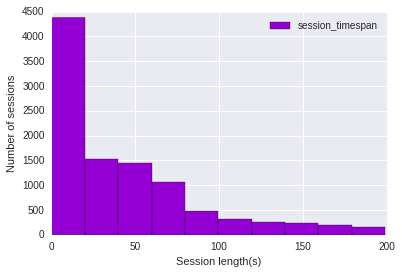

In [27]:
s = train_data_10users['session_timespan']
ax = s[s < 200].plot(kind='hist', color='darkviolet', legend=True)
ax.set_ylabel("Number of sessions")
ax.set_xlabel("Session length(s)")

As the graph shows, the distribution of the lengths of user sessions sloping to the right, dominated by short sessions. This uneven distribution tells us that the sign of the "Long session" will be useful when building the model.

**2. Build a histogram of distribution of the number of unique sites in the session(*#unique_sites*).**

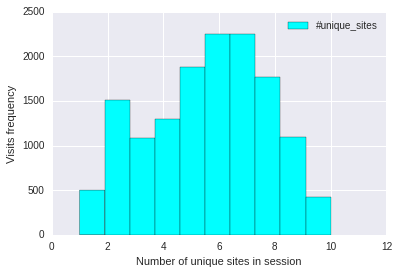

In [28]:
ax = train_data_10users['#unique_sites'].plot(kind='hist', color='aqua', legend=True)
ax.set_ylabel("Visits frequency")
ax.set_xlabel("Number of unique sites in session")

The distribution of the number of unique sites in the session almost even with the average in point 5-6. "The number of unique sites in session" will also be useful when building the model

**3. Build a histogram of the distribution of the number of unique sites in the session (*#unique_sites*) for each of the 10 users separately. **

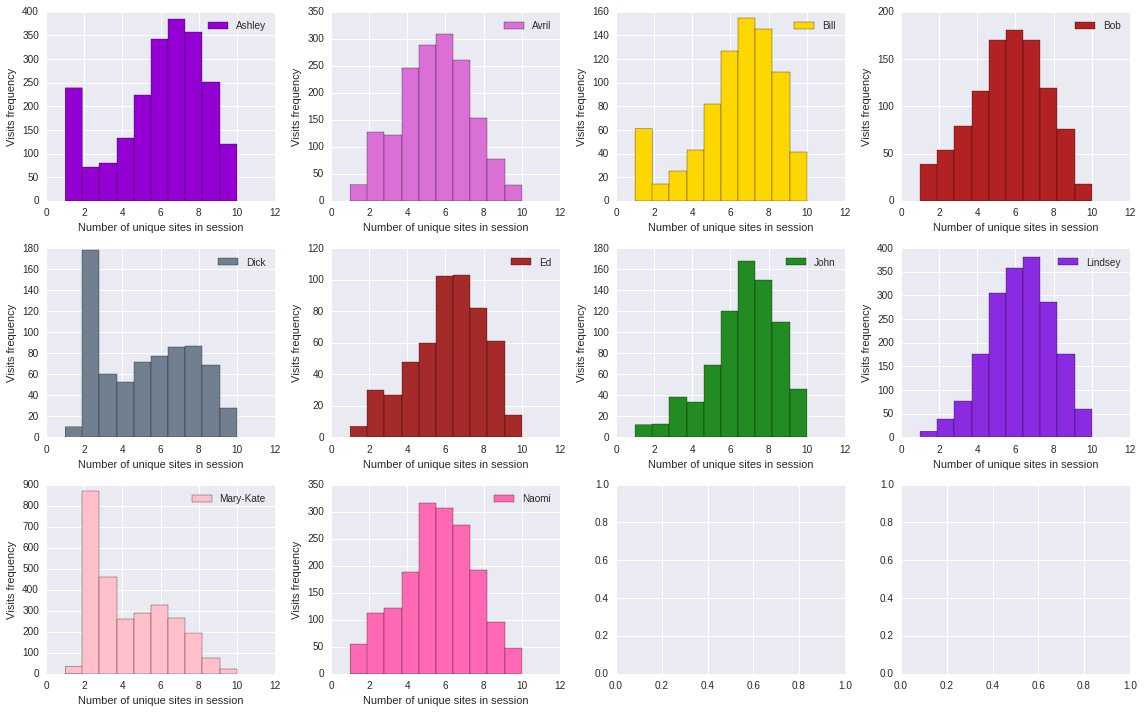

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    ax = sub_df['#unique_sites'].plot(subplots=True, kind="hist", color=color_dic[user], ax=axes[idx/4, idx%4])
    ax[0].legend(labels=[user])
    ax[0].set_ylabel("Visits frequency")
    ax[0].set_xlabel("Number of unique sites in session")

fig.tight_layout()

As we can see from the graphs the seven distributions of the number of unique site in the session is very similar, but three users - Ashley, Dick, Mary-Kate have two favorite website and often visit them. Feature "Number of unique sites in the session" I also find it useful when building the model.

**4. Build a histogram of the distribution of start hour of the session (*start_hour*).**

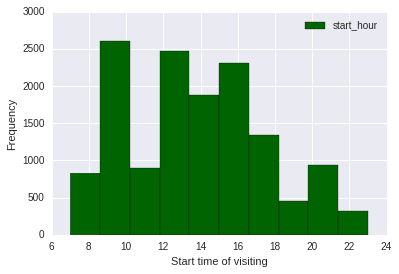

In [30]:
ax = train_data_10users['start_hour'].plot(kind='hist', color='darkgreen', legend=True)
ax.set_ylabel("Frequency")
ax.set_xlabel("Start time of visiting")

**5. Build a histogram of the distribution of start hour of users session (*start_hour*) for each of the 10 users separately.**

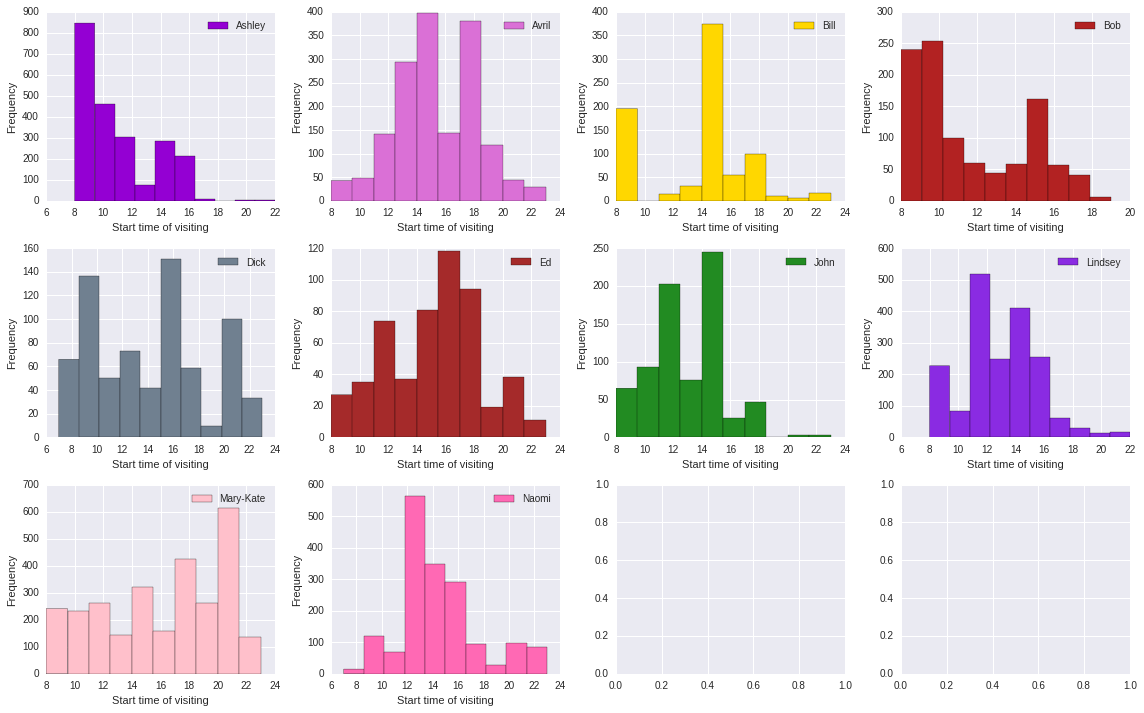

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    ax = sub_df['start_hour'].plot(subplots=True, kind="hist", color=color_dic[user], ax=axes[idx/4, idx%4])
    ax[0].legend(labels=[user])
    ax[0].set_ylabel("Frequency")
    ax[0].set_xlabel("Start time of visiting")

fig.tight_layout()

As we can see, start time distribution in the session for each user is different. Maybe it depends on the pace of life, habits and age. The majority of visits occur during lunch time, which would mean that these users are the employees of the office and actively use the Internet while lunch break.

**6. Build a histogram of the distribution of day of week on which the session began (*day_of_week*).**

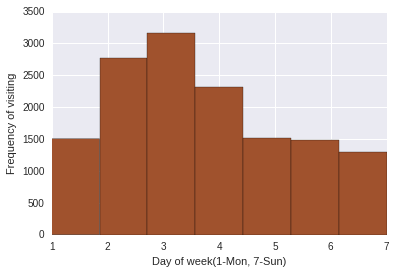

In [34]:
ax = train_data_10users['day_of_week'].hist(color='sienna', bins=7)
ax.set_ylabel("Frequency of visiting")
ax.set_xlabel("Day of week(1-Mon, 7-Sun)")

**7. Build a histogram day of week distribution when the session began (day_of_week) for each of the 10 users separately. **

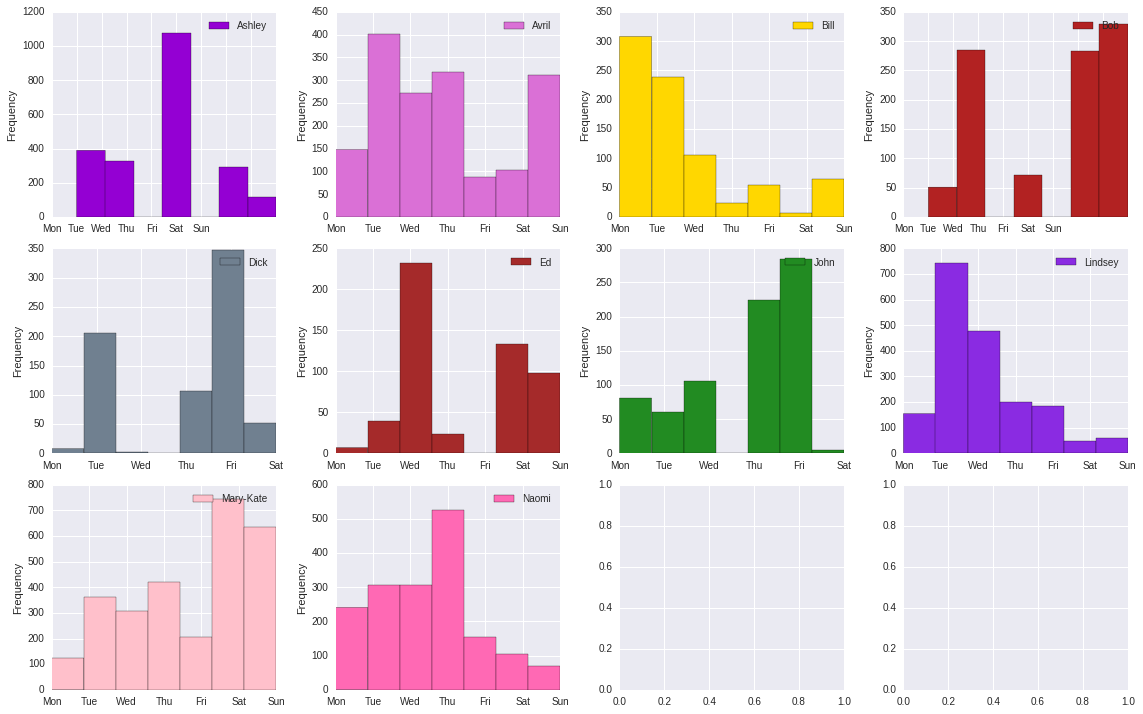

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    ax = sub_df['day_of_week'].plot(subplots=True, kind="hist", color=color_dic[user], ax=axes[idx/4, idx%4],
                                   bins=7)
    ax[0].legend(labels=[user])
    ax[0].set_ylabel("Frequency")
    ax[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig.tight_layout()

**As we can see the behavior of users differs according to the days of the week.**

**Let's take a loot at top 10 most visited websites (*top10_sites*) and the corresponding number of visits (*top10_freqs*).**

In [37]:
top_10_sorted = sorted(site_freq_150users.items(), key=lambda x: x[1][1], reverse=True)
top10_freqs = [freq[1][1] for freq in top_10_sorted[:10]]
top10_sites = [freq[0] for freq in top_10_sorted[:10]]

top10_sites

['www.google.fr',
 'www.google.com',
 'www.facebook.com',
 'apis.google.com',
 's.youtube.com',
 'clients1.google.com',
 'mail.google.com',
 'plus.google.com',
 'safebrowsing-cache.google.com',
 'www.youtube.com']

**9. Frequencies of visits to the top 10 websites.**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

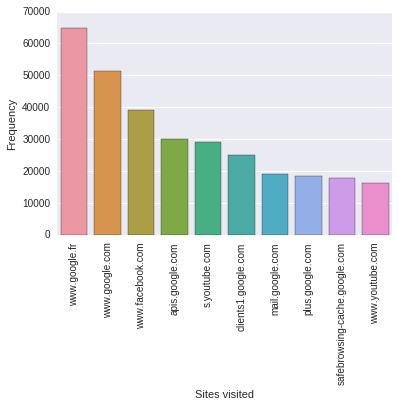

In [38]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set(xlabel='Sites visited', ylabel='Frequency')
xticks(rotation=90)

** Popularity of the sites among users is also different. This again points us to take into account the this feature, which will show how many sites from top popular user visited. **

## 3. Build and compare models

** Sometimes training of models for 150 users takes huge amount of time, sometimes even more than 24 hours, I decided separate limited 10 users sample and use it for experiments.**

In [39]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X10_pkl:
    X_sparse_10users = pickle.load(X10_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y10_pkl:
    y_10users = pickle.load(y10_pkl)

**Divide the sample into 2 parts. One will carry out cross-validation, the second is to evaluate the model trained after cross-validation.**

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

**Utility function for drawing curves validation after launch of GridSearchCV (or RandomizedCV).**

In [41]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Train random forest (RandomForestClassifier) of 100 trees. Take a look at the OOB-estimate**

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, oob_score=True, n_jobs=-1 )
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [44]:
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid))
print 'Accuracy score:', rf_valid_acc
print 'OOB score:', forest.oob_score_

Accuracy score: 0.714150272576
OOB score: 0.720077220077


**2. Train a logistic regression (LogisticRegression) with default parameter C and random_state=7 (for reproducibility). Look at the proportion of correct answers on cross-validation (use skf created earlier) and sample (X_valid, y_valid). **

In [45]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

In [46]:
logit = LogisticRegression(random_state=7, n_jobs=-1)

Evaluate Logistic Regression on cross-validation and pending sample

In [47]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf)
print u'Scross-val score ', logit_cv_scores

Scross-val score  [ 0.75159817  0.75236353  0.75350824]
CPU times: user 2.4 s, sys: 20 ms, total: 2.42 s
Wall time: 1.24 s


In [48]:
logit_ac = LogisticRegression(random_state=7, n_jobs=-1)
logit_ac.fit(X_train, y_train)

acc_score = accuracy_score(y_valid, logit_ac.predict(X_valid))
print u'Hold-out score ', acc_score

Hold-out score  0.764162123726


The average proportion of correct answers on cross-validation for each of the 10 parameters C.

In [49]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_mean_cv_scores1 = [cross_val_score(LogisticRegression(C=sc, random_state=7, n_jobs=-1), 
                                        X_train, y_train, cv=skf).mean() for sc in logit_c_values1]

print logit_mean_cv_scores1

[0.48374923572693934, 0.71825789572604348, 0.71480239235383014, 0.71297333950232822, 0.71256630910361929, 0.71205808568466677, 0.7119566763741193, 0.71083903691247008, 0.7113467959459161, 0.71053400386091692]
CPU times: user 3min 42s, sys: 2.53 s, total: 3min 45s
Wall time: 1min 53s


Draw a graph of the proportion of correct answers on cross-validation according to С.

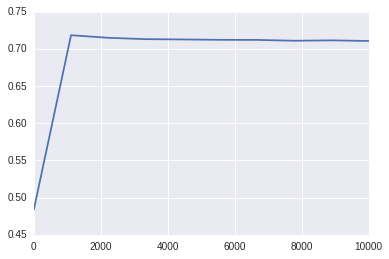

In [50]:
plot(logit_c_values1, logit_mean_cv_scores1);

**Now do the same, but search parameter C in range np.linspace(1e-3, 1, 30). **

In [51]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 10)

logit_mean_cv_scores2 = [round(cross_val_score(LogisticRegression(C=sc, random_state=7, n_jobs=-1), 
                                        X_train, y_train, cv=skf).mean(), 5) for sc in logit_c_values2]

print logit_mean_cv_scores2

[0.54075, 0.72607, 0.73735, 0.74294, 0.7469, 0.74741, 0.74853, 0.75046, 0.75178, 0.75249]
CPU times: user 19.3 s, sys: 224 ms, total: 19.5 s
Wall time: 9.84 s


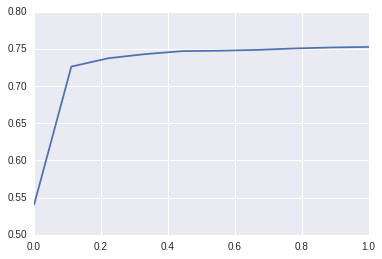

In [52]:
plot(logit_c_values2, logit_mean_cv_scores2);

**Conclusions: **

As can be seen from the experiments, LinearRegression and RandomForest show acceptable quality for the data of 10 users, but in fact, with the growth of the user sampling time and consumption of resources grow significantly. Question is these models are useful in real life is still open.

Another thing can be seen from the experiments, that visualization of the customizable options can significantly speed up their adjustment.

** 3. As we can see the build LinearRegression and RandomForest can take a lot of time, especially if you have many users. Here to the aid can come Vowpal Wabbit bulky, ugly and repulsive, but as an old tractor crushing all in its path, taking minimum time, making good stuff with good quality. **

For VW, we will conduct experiments on 150 users

In [53]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X150_pkl:
    X_sparse_150users = pickle.load(X150_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y150_pkl:
    y_150users = pickle.load(y150_pkl)

**Vowpal Wabbit likes that the class labels were distributed from 1 to K, where K is the number of classes in a classification problem (in our case 150). So we'll have to apply LabelEncoder, and even +1 then add (LabelEncoder translates labels in a range from 0 to K-1).**

In [54]:
class_encoder = LabelEncoder().fit(y_150users.astype('str'))
y_for_vw = class_encoder.transform(y_150users.astype('str')) + 1

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_150users, y_for_vw, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_for_vw)

**Implement a function that transforms the sparse matrix format Vowpal Wabbit.**

In [56]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):
    with open(out_file, 'w') as out_file_data:
        for i in xrange(np.shape(X_sparse)[0]):
            if y != None:
                s = '{0} | sites'.format(y[i])
            else:
                s = '1 | sites'
            indices_data = zip(X_sparse[i].indices, X_sparse[i].data)  
            
            out_file_data.write(s + ''.join(map(lambda pair: ' {0}:{1} '.format(pair[0], pair[1]), indices_data))
                                + '\n')

**Apply a function to the training sample (X_train, y_train) and hold-out sample (X_valid, y_valid).**

In [57]:
sparse_matrix_to_vw(X_train, y_train, 'train_part.vw')
sparse_matrix_to_vw(X_valid, y_valid, 'valid.vw')

**Evaluate the first 5 rows of the train, validation.**

In [59]:
!head -5 train_part.vw

50 | sites 3610:1  3595:1  3593:2  211:3  2:3 
105 | sites 13555:1  13554:1  11192:1  3344:1  292:1  291:1  224:1  0:3 
65 | sites 1041:2  244:3  28:1  27:2  2:1  0:1 
114 | sites 9371:1  289:1  288:1  244:1  211:1  27:3  5:1  1:1 
116 | sites 476:1  69:1  68:2  40:3  2:2  0:1 


In [60]:
!head -5 valid.vw

104 | sites 17385:1  17384:2  295:1  290:1  265:3  36:2 
16 | sites 27:3  26:4  1:3 
41 | sites 10651:10 
38 | sites 1153:1  1152:1  1151:1  457:1  328:1  306:1  6:2  2:1  0:1 
136 | sites 21908:1  19912:1  7904:2  1227:1  1226:1  1225:1  709:1  201:1  0:1 


**Train the model on a sample of train_part.vw. Point out, that we solve the problem of classification with 150 classes (*--oaa*), will make 10 passes through the sample (*--passes*). Set cache file (*--cache_file*), so the VW will be faster after the first passages in the sample (past the cache file is removed with the help of the argument *-k*). Also set value of the parameter b=26. Its the number of bits used for hashing, in our case we need more than the default 18.**

In [62]:
%%time
!vw -d train_part.vw -k -b 26 --oaa 150  --passes 10 --cache_file train_part.cachef \
-f train_part.model --random_seed=123 

final_regressor = train_part.model
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train_part.cachef
Reading datafile = train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       50        1        7
1.000000 1.000000            2            2.0      105       50       10
1.000000 1.000000            4            4.0      114       65       10
1.000000 1.000000            8            8.0       38      105        5
0.937500 0.875000           16           16.0       88       83        5
0.968750 1.000000           32           32.0      105       95        3
0.953125 0.937500           64           64.0       75      150       10
0.937500 0.921875          128          128.0      136       21        8
0.929688 0.921875          256          256.0       8

**Write predictions on a sample *valid.vw* in *vw_valid_pred.csv*. **

In [63]:
%%time
!vw -i train_part.model -t -d valid.vw -p vw_valid_pred.csv --random_seed=123

only testing
predictions = vw_valid_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      104        2        8
1.000000 1.000000            2            2.0       16       65        5
0.750000 0.500000            4            4.0       38       47       11
0.500000 0.250000            8            8.0      115      115       10
0.500000 0.500000           16           16.0      115      115        6
0.437500 0.375000           32           32.0       10       10        8
0.468750 0.500000           64           64.0      115      115        8
0.476562 0.484375          128          128.0      148       99        3
0.507812 0.539062          256          256.0       36        4        8
0.531250 0.554688       

**Read predictions from *vw_valid_pred.csv* file and look at the proportion of correct answers on the hold-out part.**

In [65]:
vw_valid_pred = pd.read_csv('vw_valid_pred.csv', names=['target'])
acc_score = accuracy_score(y_valid, vw_valid_pred)
print 'accuracy', acc_score

accuracy 0.446041940349


## 4. Further feature engineering

** So, we get Accuracy score: 0.4460 on hold-out dataset. Seemed not to be so much, but note how faster model was trained and in addition we used all 150 users! Also note that we have trained model on a sample consisting only of information about visited sites. Let's extend our dataset with more features. **

While doing <a href="#2.-Visual-analysis-of-data">Visual analysis of data</a>, we noticed that user behavior differs according to time and day of the week. Some users more active in the morning, some in the evening. I think these signs are important, because usually if the person was active in the morning, and then started to visit many sites in the evening, and not from a set it is most often visited, - it is a direct hint that this account may be used by someone else. So, I decided to add such features:

* The number of unique sites in the session
* The day of the beginning session (work-day)
* Time of day
* Top 30 most visited websites by the user

In [66]:
def feature_engineering(csv_files_mask, site_freq_path, feature_names, session_length=10, window_size=1, f_type=(True, True)):
    FMT = '%Y-%m-%dT%H:%M:%S'
    user_session = []

    features_len = len(feature_names)

    if window_size == 1:
        window_size = session_length

    with open(site_freq_path, 'rb') as XX_pkl:
        freq_dict = pickle.load(XX_pkl)

    for file_name in sorted(glob(csv_files_mask)):

        data = pd.read_csv(file_name, names=['user_id', 'date', 'site'])
        user_id = data['user_id'][0]

        end_idx = session_length
        rows_count = data.shape[0]

        if f_type[0] and f_type[1]:
            top_30_sorted = sorted(freq_dict.items(), key=lambda x: x[1][1], reverse=True)
            user_top30_sites = [freq[0] for freq in top_30_sorted[:10]]

        for start_idx in xrange(0, rows_count, window_size):
            if end_idx >= rows_count:
                data_slice = data[start_idx:rows_count]
            else:
                data_slice = data[start_idx:end_idx]

            if end_idx + window_size > rows_count:
                end_idx = rows_count
            else:
                end_idx += window_size

            # build session row
            session = np.zeros(features_len, dtype=np.int32)
            data_slice_len = len(data_slice)
            tm_diff = time_diff2(data_slice)

            if f_type[0] and f_type[1]:
                # uniques
                uniques = data_slice['site'].unique()
                session[0] = len(uniques)
                # start_hour
                session[1] = tm_diff["start_hour"]
                # day_of_week
                session[2] = tm_diff["day_of_week"]
                # how much site from user's top 20 he saw in session
                session[3] = len([st for st in uniques if st in user_top30_sites])
                # part of the day
                if 6 < tm_diff["start_hour"] < 13:
                    session[4] = 1
                if 12 < tm_diff["start_hour"] < 19:
                    session[4] = 2
                if tm_diff["start_hour"] > 18:
                    session[4] = 3
                if 0 < tm_diff["start_hour"] < 7:
                    session[4] = 4

                if tm_diff["day_of_week"] < 6:
                    session[5] = 1
                else:
                    session[5] = 2

            # target
            session[features_len - 1] = user_id

            user_session.append(session.tolist())

    return pd.DataFrame(data=user_session, columns=feature_names)

** Prepare dataset for 10 users only **

In [67]:
feature_names = ['#unique_sites', 'start_hour', 'day_of_week', '#of_top_30', 'time_of_day', 'working_day', 'target']

new_features_10users = feature_engineering('capstone_websites_data/10users/*', 'capstone_websites_data/site_freq_10users.pkl',
                                      feature_names, session_length=10)

In [68]:
new_features_10users.head()

,#unique_sites,start_hour,day_of_week,#of_top_30,time_of_day,working_day,target
0,8,8,5,2,1,1,31
1,8,8,5,1,1,1,31
2,7,8,5,2,1,1,31
3,6,8,5,0,1,1,31
4,10,8,5,0,1,1,31


##### So, let's see how users behave during the day:

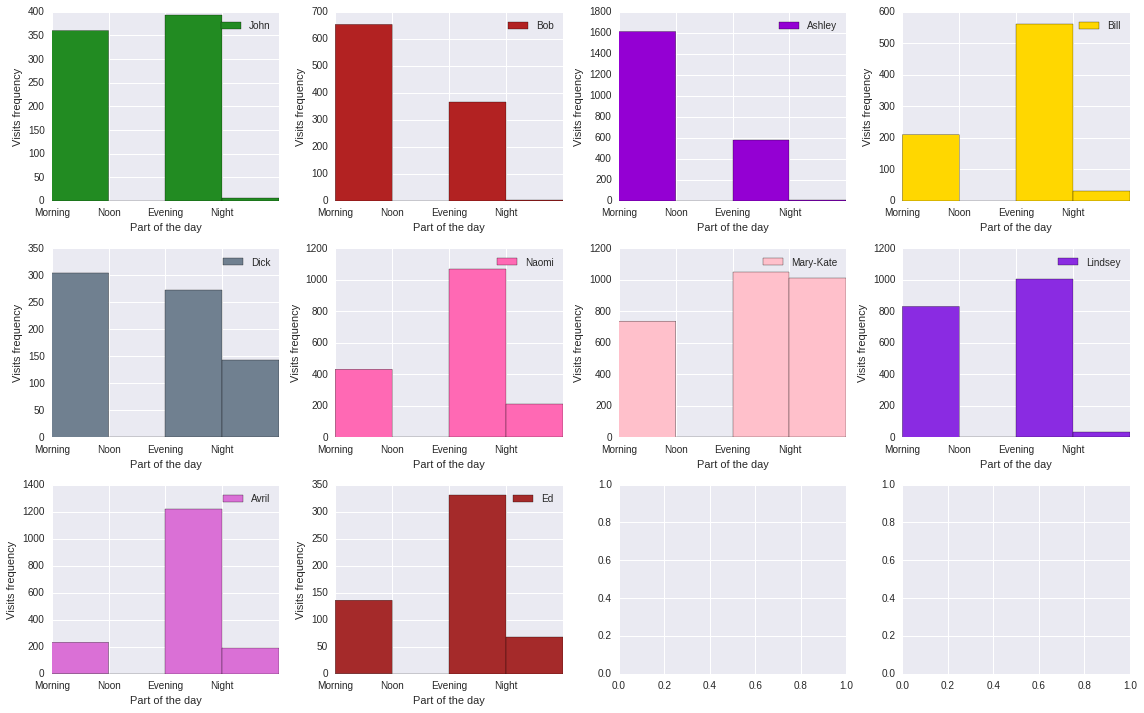

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    ax = sub_df['time_of_day'].plot(subplots=True, kind="hist", color=color_dic[id_name_dict[user]],
                                      ax=axes[idx/4, idx%4], bins=4)
    ax[0].legend(labels=[id_name_dict[user]])
    ax[0].set_ylabel("Visits frequency")
    ax[0].set_xlabel("Part of the day")
    ax[0].set_xticklabels(['Morning', 'Noon', 'Evening', 'Night'])

fig.tight_layout()

##### User behavior on weekdays and weekends:

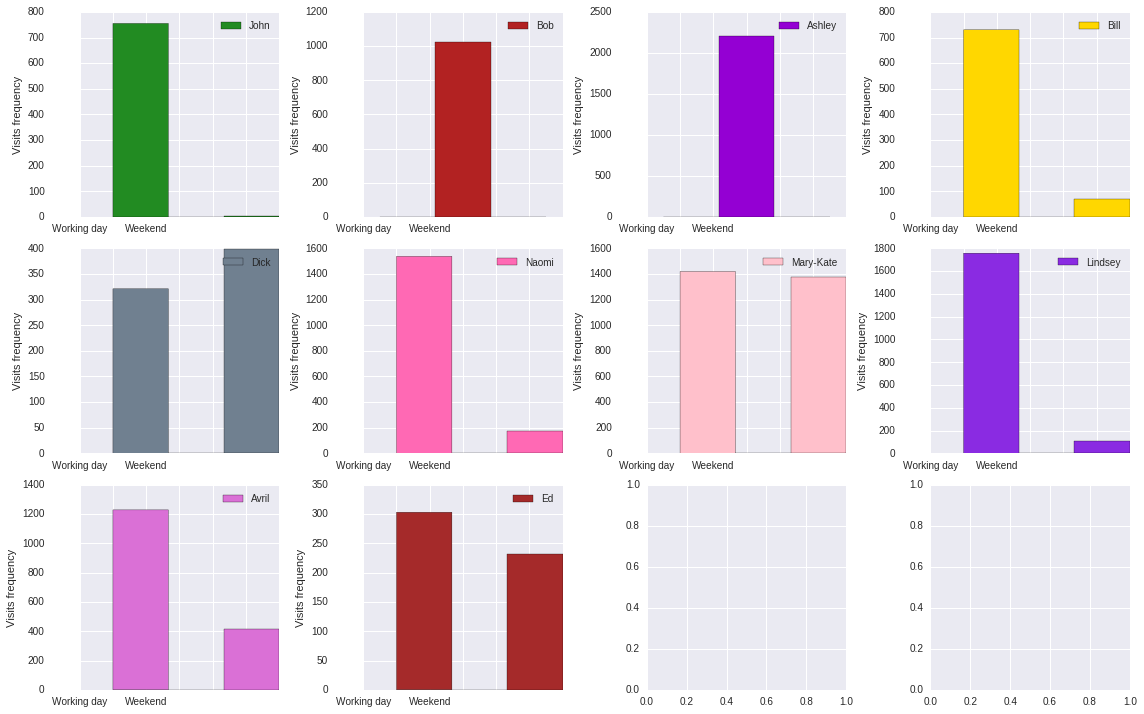

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):    
    ax = sub_df['working_day'].plot(subplots=True, kind="hist", color=color_dic[id_name_dict[user]], legend=False, 
                                    ax=axes[idx/4, idx%4], bins=3)
    ax[0].yaxis.set_tick_params(pad=35)
    ax[0].legend(labels=[id_name_dict[user]])
    ax[0].set_ylabel("Visits frequency")
    ax[0].set_xticklabels(['Working day', "" , 'Weekend'])

fig.tight_layout()

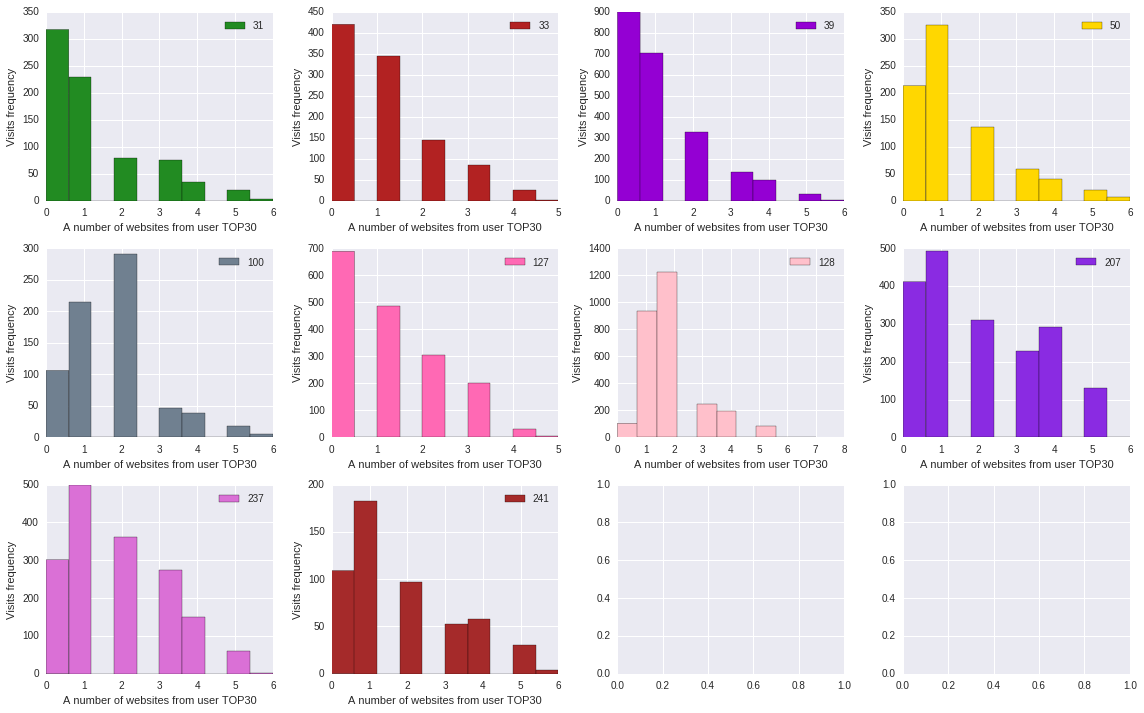

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    ax = sub_df['#of_top_30'].plot(subplots=True, kind="hist", color=color_dic[id_name_dict[user]], 
                                   legend=False, ax=axes[idx/4, idx%4], bins=10)
    ax[0].legend(labels=[user])
    ax[0].set_ylabel("Visits frequency")
    ax[0].set_xlabel("A number of websites from user TOP30")

fig.tight_layout()

** As we see, the new features perfectly show the difference in the behavior of users and thus can help us improve accuracy score. **

**Prepare dataset for all 150 users**

In [73]:
feature_names = ['#unique_sites', 'start_hour', 'day_of_week', '#of_top_30', 'time_of_day', 'working_day', 'target']
new_features_150users = feature_engineering('capstone_websites_data/150users/*', 'capstone_websites_data/site_freq_150users.pkl',
                                      feature_names, session_length=10)

In [74]:
new_features_150users.head()

,#unique_sites,start_hour,day_of_week,#of_top_30,time_of_day,working_day,target
0,6,8,5,3,1,1,6
1,3,8,5,1,1,1,6
2,5,9,5,1,1,1,6
3,6,9,5,0,1,1,6
4,6,9,5,0,1,1,6


In [211]:
y_target = new_features_150users.iloc[:, -1]
nf_150users = new_features_150users.iloc[:, :-1]
nf_150users.head()

,#unique_sites,start_hour,day_of_week,#of_top_30,time_of_day,working_day
0,6,8,5,3,1,1
1,3,8,5,1,1,1
2,5,9,5,1,1,1
3,6,9,5,0,1,1
4,6,9,5,0,1,1


** We must remember that the features start_hour, day_of_week, time_of_day , working_day - categorical, they have to be binarized before using**

In [234]:
from sklearn.preprocessing import OneHotEncoder
binarized = OneHotEncoder().fit_transform(nf_150users)

_X_150users = sp_hstack((X_sparse_150users,  binarized)).tocsr()
print np.shape(_X_150users)

(137019, 27844)


In [235]:
X_train, X_valid, y_train, y_valid = train_test_split(_X_150users, y_for_vw, 
                                                      test_size=0.3, 
                                                      random_state=7, 
                                                      stratify=y_for_vw)

In [229]:
print np.shape(_X_150users)
print np.shape(y_for_vw)

(137019, 27844)
(137019,)


**Convert to format VW**

In [236]:
sparse_matrix_to_vw(X_train, y_train, 'train_part.vw')
sparse_matrix_to_vw(X_valid, y_valid, 'valid.vw')

In [216]:
!head -5 train_part.vw

50 | sites 27852:1.0  27850:1.0  27843:1.0  27834:1.0  27826:1.0  27811:1.0  27804:1.0  27802:1.0  27801:1.0  27799:1.0  27797:1.0  3610:1.0  3595:1.0  3593:2.0  211:3.0  2:3.0 
105 | sites 27852:1.0  27849:1.0  27843:1.0  27836:1.0  27821:1.0  27814:1.0  27804:1.0  27802:1.0  27800:1.0  27799:1.0  27798:1.0  13555:1.0  13554:1.0  11192:1.0  3344:1.0  292:1.0  291:1.0  224:1.0  0:3.0 
65 | sites 27852:1.0  27850:1.0  27844:1.0  27835:1.0  27825:1.0  27812:1.0  27805:1.0  27804:1.0  27803:1.0  27802:1.0  27801:1.0  27800:1.0  27799:1.0  1041:2.0  244:3.0  28:1.0  27:2.0  2:1.0  0:1.0 
114 | sites 27853:1.0  27851:1.0  27844:1.0  27840:1.0  27830:1.0  27814:1.0  27803:1.0  27802:1.0  27801:1.0  27800:1.0  27799:1.0  27798:1.0  9371:1.0  289:1.0  288:1.0  244:1.0  211:1.0  27:3.0  5:1.0  1:1.0 
116 | sites 27852:1.0  27849:1.0  27844:1.0  27836:1.0  27818:1.0  27812:1.0  27805:1.0  27804:1.0  27802:1.0  27801:1.0  27800:1.0  27799:1.0  27798:1.0  27797:1.0  476:1.0  69:1.0  68:2.0  40:3.0

In [217]:
!head -5 valid.vw

104 | sites 27852:1.0  27850:1.0  27841:1.0  27838:1.0  27825:1.0  27812:1.0  27804:1.0  27799:1.0  17385:1.0  17384:2.0  295:1.0  290:1.0  265:3.0  36:2.0 
16 | sites 27852:1.0  27851:1.0  27844:1.0  27838:1.0  27829:1.0  27809:1.0  27805:1.0  27804:1.0  27803:1.0  27802:1.0  27801:1.0  27800:1.0  27798:1.0  27797:1.0  27:3.0  26:4.0  1:3.0 
41 | sites 27852:1.0  27849:1.0  27841:1.0  27835:1.0  27820:1.0  27807:1.0  27805:1.0  27804:1.0  27803:1.0  27802:1.0  27801:1.0  27800:1.0  27799:1.0  27798:1.0  27797:1.0  10651:10.0 
38 | sites 27852:1.0  27849:1.0  27843:1.0  27836:1.0  27821:1.0  27815:1.0  27805:1.0  27802:1.0  27799:1.0  1153:1.0  1152:1.0  1151:1.0  457:1.0  328:1.0  306:1.0  6:2.0  2:1.0  0:1.0 
136 | sites 27852:1.0  27849:1.0  27842:1.0  27838:1.0  27820:1.0  27815:1.0  27805:1.0  27803:1.0  27802:1.0  27801:1.0  27800:1.0  21908:1.0  19912:1.0  7904:2.0  1227:1.0  1226:1.0  1225:1.0  709:1.0  201:1.0  0:1.0 


** Train model **

In [237]:
%%time
!vw -d train_part.vw -k -b 26 --oaa 150  --passes 10 --cache_file train_part.cachef \
-f train_part.model --random_seed=123 

final_regressor = train_part.model
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train_part.cachef
Reading datafile = train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       50        1       13
1.000000 1.000000            2            2.0      105       50       16
1.000000 1.000000            4            4.0      114       65       16
1.000000 1.000000            8            8.0       38      105       11
1.000000 1.000000           16           16.0       88       40       11
1.000000 1.000000           32           32.0      105        7        9
0.968750 0.937500           64           64.0       75       42       16
0.960938 0.953125          128          128.0      136      115       14
0.949219 0.937500          256          256.0       8

**Write predictions on a sample *valid.vw* in *vw_valid_pred.csv*. **

In [238]:
%%time
!vw -i train_part.model -t -d valid.vw -p vw_valid_pred.csv --random_seed=123

only testing
predictions = vw_valid_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      104       13       14
1.000000 1.000000            2            2.0       16       88       11
0.750000 0.500000            4            4.0       38       93       17
0.375000 0.000000            8            8.0      115      115       16
0.437500 0.500000           16           16.0      115      115       12
0.437500 0.437500           32           32.0       10       10       14
0.453125 0.468750           64           64.0      115      115       14
0.414062 0.375000          128          128.0      148       99        9
0.445312 0.476562          256          256.0       36        4       14
0.460938 0.476562       

** Estimation on hold-out dataset**

In [239]:
vw_valid_pred = pd.read_csv('vw_valid_pred.csv', names=['target'])
acc_score = accuracy_score(y_valid, vw_valid_pred)
print 'accuracy', acc_score

accuracy 0.520094390113


** We see that adding new features improved the accuracy of our predictions from 0.44 to 0.52**

## 5. Conclusion

From my work I can make some important conclusions:
1. Models in Machine Learning work in different ways and, of course, can give predictions with different levels of uncertainty. Theoretically, more complex models are more accurate but they have a downside, for large data, they can be very voracious in the consumption of resources and don't make predictions for an adequate time. If the sample is small, it is best to use more complex and accurate algorithms, but in reality, when the data becomes bigger online learning methods much better suited. They use much less resources, work in a reasonable time and most importantly, additionaly train in mean time. Of course, this flexibility comes at the cost of accuracy of the predictions, but increasing the sample size accuracy precision can grow. 


2. User identification can have very wide application in such areas as:
  * First, we have already identified at the beginning of the study - identification that someone's account was hacked
  * Correct user targeting for advertising and services. Knowing the habits of the user can create user's profile and offer him more relevant ads or services.
    

3. What could be improved? I think one improvement could be a generation of new features. As shown in the experiment, addition of new relevant features improves the prediction of the model. You can try to add such features combinations as 'month-week', 'day of the week-start time of the session' and so on. But with the combination of features it is important not to adjust model to a training sample, because it can lead to overfitting and as a result bad prediction capability on new data. 

You can still spend more time and computing resources and to try to adjust and optimize the algorithm. Visualisation can significantly accelerate the selection of parameters, a optimization using a grid search to better fine - tune the model.